<h1>Customer Segmentation</h1>

<i>N.Avgeros (March 2022)</i>

---

<h3>Introduction</h3>

This notebook aims at predicting the sentiment of customers' reviews. It is simply a sentiment analysis project, including various machine learning techniques to detect the customers' sentiment. In addition, it provides an introductory knowledge of NLP's "Data Preprocessing", "Bag Of Words" and "Machine Learning" steps.


<h3>Natural Language Processing (NLP)</h3>

Natural Language Processing (NLP) is a type of computational linguistics that uses machine learning algorithms to understand how us people communicate. This includes voice assistance, chat bots, sentiment analysis and many more.

With NLP, computers can understand human speech in text and written form without the need of someone to structure their conversation in any way.

<h3>What we'll be doing</h3>

In this kernel, the main steps for any NLP problem will be described, as well as their lines of code. This will help further analysis and will be a good starting point to build more complex models.

In the dataset of this exercise we have 1000 reviews from a restaurant, labeled as positive reviews (1) or negative ones (0).

We will be building different machine learning models that may predict, given the words used in the review, a label for each of the reviews in the test set.

<h3>Sentiment Analysis</h3>

Sentiment Analysis (also known as opinion mining or emotion AI) is a sub-field of NLP that tries to identify and extract opinions within a given text across blogs, reviews, social media, forums, news etc. Sentiment Analysis can help craft all this exponentially growing unstructured text into structured data using NLP and open source tools. This is what we are going to do here.

#### Context

Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, The UCI Machine Learning Repository has made this dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail".

#### Content

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

#### Inspiration

Analyses for this dataset could include time series, clustering, classification and more.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain, cycle
from datetime import datetime, timedelta
import pycountry_convert as pc
from IPython.display import display, display_html
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

#### Changing CSS styling

In [2]:
%%HTML
<style>.dataframe th{
background:#3f577c; 
font-family:monospace;
padding: 5px;
color:white;
border:1px solid white; 
text-align:center !important;}
</style>

## 1. Data exploration

In [3]:
data_df = pd.read_csv("data.csv", encoding="ANSI")
data_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# Dataset overview
def df_overview(df):
    """ 
    Overview of missing data, dimension & duplicates in a dataframe 
    
    Inputs
    ------
        Dataframe
    
    Returns
    -------
        Dataframe using the display function from IPython.display package order by Total in descending order
        
    """
    
    overview_df = pd.DataFrame({"Total":df.isna().sum()})
    overview_df["% Missing"] = round((overview_df["Total"] / len(df)) * 100, 1)
    overview_df["Type"] = df.dtypes
    duplicates_df = df[df.duplicated()]
    print("Dimensions: {}\nDuplicates: {}".format(df.shape, len(duplicates_df)))
    return display(overview_df.sort_values(by="Total", ascending=False))


# Compare Dataframes
def df_compare(*args, titles=cycle([''])):
    
    """ 
    Display dataframes side by side 
    
    Inputs
    ------
        *args: pandas dataframes
        titles: titles of each dataframe
    
    Returns
    -------
        pandas dataframes displayed side by side by using the display_html() function from IPython.display package

    """
    
    html_str=''
    
    for df,title in zip(args, chain(titles,cycle(['</br>']))):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
        
    display_html(html_str,raw=True)

In [5]:
df_overview(data_df)

Dimensions: (541909, 8)
Duplicates: 5268


,Total,% Missing,Type
CustomerID,135080,24.9,float64
Description,1454,0.3,object
InvoiceNo,0,0.0,object
StockCode,0,0.0,object
Quantity,0,0.0,int64
InvoiceDate,0,0.0,object
UnitPrice,0,0.0,float64
Country,0,0.0,object


## 2. Data cleaning

<ol>
    <li>Change InvoiceDate type to datatime</li>
    <li>Handle missing values</li>
</ol>

In [6]:
clean_df = data_df.copy()
clean_df["InvoiceDate"] = pd.to_datetime(clean_df["InvoiceDate"])
display(clean_df[clean_df["CustomerID"].isnull()].head())
clean_df.dropna(axis=0, subset=['CustomerID'], inplace=True)
clean_df.drop_duplicates(inplace=True)
df_overview(clean_df)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


Dimensions: (401604, 8)
Duplicates: 0


,Total,% Missing,Type
InvoiceNo,0,0.0,object
StockCode,0,0.0,object
Description,0,0.0,object
Quantity,0,0.0,int64
InvoiceDate,0,0.0,datetime64[ns]
UnitPrice,0,0.0,float64
CustomerID,0,0.0,float64
Country,0,0.0,object


## Data exploration

This dataframe contains 8 variables that correspond to:


#### InvoiceNo:
Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
#### StockCode:
Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
#### Description:
Product (item) name. Nominal.
#### Quantity:
The quantities of each product (item) per transaction. Numeric.
#### InvoiceDate:
Invice Date and time. Numeric, the day and time when each transaction was generated.
#### UnitPrice:
Unit price. Numeric, Product price per unit in sterling.
#### CustomerID:
Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
#### Country:
Country name. Nominal, the name of the country where each customer resides.

## 2.1 Analysis

Let's make a copy of the cleaned dataset as we are going to create new calculated columns.

In [26]:
# Continent
def get_continent(country):
    """ Finds the continent from a given country """
    if country in ['EIRE', 'European Community', "Channel Islands"]:
        return 'Europe'
    elif country == 'RSA':
        return 'Africa'
    elif country == "Unspecified":
        return country
    else:  
        continents = {
                'NA': 'North America',
                'SA': 'South America', 
                'AS': 'Asia',
                'OC': 'Australia',
                'AF': 'Africa',
                'EU': 'Europe',
            }
        return continents[pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))] 

In [27]:
analysis_df = clean_df.copy()
analysis_df["Continent"] = analysis_df["Country"].map(get_continent)
analysis_df["Cancelled"] = (analysis_df["InvoiceNo"].str.contains('C')>0).astype(int)
analysis_df["Amount"] = analysis_df["Quantity"] * analysis_df["UnitPrice"]
display(analysis_df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Continent,Cancelled,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Europe,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Europe,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe,0,20.34


### Peculiar transactions 

<ul>
    <li>POST -> POSTAGE</li>                    
    <li>D -> Discount</li>                   
    <li>C2 -> CARRIAGE</li>                   
    <li>M -> Manual</li>                   
    <li>BANK CHARGES -> Bank Charges</li>               
    <li>PADS -> PADS TO MATCH ALL CUSHIONS</li> 
    <li>DOT -> DOTCOM POSTAGE</li> 
<ul>

In [227]:
special_codes_df = analysis_df[analysis_df.StockCode.str.contains('^[a-zA-Z]')]
display(special_codes_df)
special_codes_lst = special_codes_df.StockCode.unique().tolist()
print("Special stock codes: {}".format(', '.join(special_codes_lst)))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Continent,Cancelled,Amount
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France,Europe,0,54.00
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,Europe,1,-27.50
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791.0,Netherlands,Europe,0,15.00
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662.0,Germany,Europe,0,18.00
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.00,14911.0,EIRE,Europe,0,50.00
...,...,...,...,...,...,...,...,...,...,...,...
541216,581494,POST,POSTAGE,2,2011-12-09 10:13:00,18.00,12518.0,Germany,Europe,0,36.00
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,Europe,1,-224.69
541730,581570,POST,POSTAGE,1,2011-12-09 11:59:00,18.00,12662.0,Germany,Europe,0,18.00
541767,581574,POST,POSTAGE,2,2011-12-09 12:09:00,18.00,12526.0,Germany,Europe,0,36.00


Special stock codes: POST, D, C2, M, BANK CHARGES, PADS, DOT, CRUK



### Top 15 customers by Quantity, Amount, Products, Transactions, Cancellations

In [232]:
# Transactions by customer
transactions_dict = dict()
for customer, group in analysis_df.groupby(["CustomerID"]):
    if not transactions_dict.get(customer, 0): 
        transactions_dict[customer] = group["InvoiceDate"].tolist()
    else:
        transactions_dict[customer].append(group["InvoiceDate"].tolist())   
transactions_dict = {key: Counter(value) for key, value in transactions_dict.items()}

# Create customers' profile
customers_details_df = analysis_df.groupby(['CustomerID']).agg({
    'Quantity' : 'sum',
    'UnitPrice' : 'sum',
    'Cancelled' : 'sum',
    'Amount': 'sum'
}).join( # Transactions per customer
    pd.DataFrame({key:[len(value)] for key, value in transactions_dict.items()},
                 index=["Transactions"]).T
 ).join( # Last Transaction per customer
    pd.DataFrame({key: list(transactions_dict[key].keys())[-1] for key in transactions_dict.keys()},
                 index=['LastTransaction']).T
).join( # Country & Continent 
    analysis_df.drop_duplicates(subset='CustomerID', keep='first').set_index('CustomerID')[["Country", 'Continent']]
).join( # Products bought per customer excluding special charges (POST, D, C2, M, BANK CHARGES, PADS, DOT, CRUK)
    analysis_df[~(analysis_df['StockCode'].isin(special_codes_lst))].groupby(
        'CustomerID').count()[['InvoiceNo']].rename(columns={'InvoiceNo':'Products'})
)

# Reorder columns
customers_details_df = customers_details_df.reindex(columns=['Quantity', 'UnitPrice', 'Amount', 'Country',
                                                             'Continent','Products', 'Transactions', 
                                                             'Cancelled', 'LastTransaction'])
# Order by function
def df_ordering(df, order_by, ascending=False, records_num=15):
    """Returns N highest or lowest record from a dataframe"""
    return df.sort_values(by=order_by, ascending=ascending).head(records_num)

df_compare(df_ordering(customers_details_df[['Quantity']], 'Quantity'),
                   df_ordering(customers_details_df[['Amount']], 'Amount'),
                   df_ordering(customers_details_df[['Products']], 'Products'),
                   df_ordering(customers_details_df[['Transactions']], 'Transactions'),
                   df_ordering(customers_details_df[['Cancelled']], 'Cancelled'),
                   titles=['By Quantity','By Amount','By Products','By Transactions','By Cancellations'])

,Quantity
CustomerID,
14646.0,196719
12415.0,77242
14911.0,77155
17450.0,69009
18102.0,64122
17511.0,63012
13694.0,61899
14298.0,58021
14156.0,56908


### Overview customer's profile and activity

In [237]:
def customer_profile(customer_id, details=None):
    """ Returns customer's profile and transactions """
    
    transactions_df = analysis_df[analysis_df["CustomerID"]==customer_id].drop(columns=['CustomerID', 'Country', 'Continent'])
    profile_df = pd.DataFrame(customers_details_df.loc[customer_id, :])
    return df_compare(profile_df, transactions_df, titles=["Profile", "Transactions"])

In [238]:
customer_profile(12791.0)

Profile 
 
 
 
 12791.0 
 
 
 
 
 Quantity 
 97 
 
 
 UnitPrice 
 16.85 
 
 
 Amount 
 192.6 
 
 
 Country 
 Netherlands 
 
 
 Continent 
 Europe 
 
 
 Products 
 1.0 
 
 
 Transactions 
 1 
 
 
 Cancelled 
 0 
 
 
 LastTransaction 
 2010-12-01 11:27:00 
 
 
 Transactions 
 
 
 
 InvoiceNo 
 StockCode 
 Description 
 Quantity 
 InvoiceDate 
 UnitPrice 
 Cancelled 
 Amount 
 
 
 
 
 385 
 536403 
 22867 
 HAND WARMER BIRD DESIGN 
 96 
 2010-12-01 11:27:00 
 1.85 
 0 
 177.6 
 
 
 386 
 536403 
 POST 
 POSTAGE 
 1 
 2010-12-01 11:27:00 
 15.00 
 0 
 15.0

### Cancelled invoices

In [32]:
df_compare(pd.DataFrame(analysis_df["Cancelled"].value_counts()),
           pd.DataFrame(analysis_df["Cancelled"].value_counts(normalize=True)*100),
           titles=["Total", "Percentage"])

,Cancelled
0,392732
1,8872
,Cancelled
0,97.790859
1,2.209141


### Countries and continents were the most orders made

In [33]:
# Country
country_df = pd.DataFrame({"Orders":analysis_df["Country"].value_counts(),
              "% Orders": round((analysis_df["Country"].value_counts(normalize=True)*100), 4)})

# Continent
continent_df = pd.DataFrame({"Orders":analysis_df["Continent"].value_counts(),
              "% Orders": round((analysis_df["Continent"].value_counts(normalize=True)*100), 4)})

# Country & Continent
df_compare(country_df.head(15), continent_df, titles=['By Country (Top 15)','By Continent'])

,Orders,% Orders
United Kingdom,356728,88.8258
Germany,9480,2.3605
France,8475,2.1103
EIRE,7475,1.8613
Spain,2528,0.6295
Netherlands,2371,0.5904
Belgium,2069,0.5152
Switzerland,1877,0.4674
Portugal,1471,0.3663
Australia,1258,0.3132


### Monthly Revenue

,Amount
InvoiceDate,
2010-12-31,552372.860
2011-01-31,473731.900
2011-02-28,435534.070
2011-03-31,578576.210
2011-04-30,425222.671
2011-05-31,647011.670
2011-06-30,606862.520
2011-07-31,573112.321
2011-08-31,615078.090


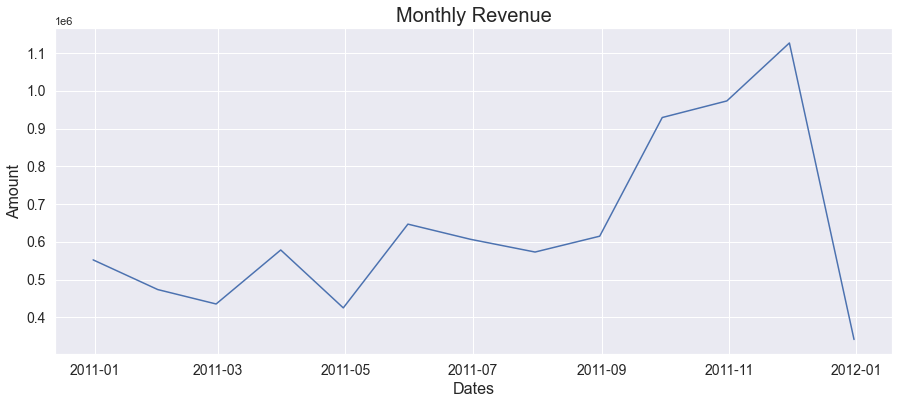

In [34]:
monthly_revenue_df = (analysis_df.groupby(["InvoiceDate"]).sum()[["Amount"]]).resample('M').sum()

# InvoiceDate & Amount
df_compare(df_ordering(monthly_revenue_df, "InvoiceDate", ascending=True, records_num=len(monthly_revenue_df)), 
           df_ordering(monthly_revenue_df, "InvoiceDate", ascending=False, records_num=len(monthly_revenue_df)), 
           df_ordering(monthly_revenue_df, "Amount", ascending=True, records_num=len(monthly_revenue_df)),
           df_ordering(monthly_revenue_df, "Amount", ascending=False, records_num=len(monthly_revenue_df)),
           titles=['InvoiceDate ASC','InvoiceDate DESC', "Amount ASC", "Amount DESC"])

# Plot Monthly Revenue
plt.figure(figsize=(15,6))
sns.lineplot(x='InvoiceDate', y='Amount', data=monthly_revenue_df)
plt.figsize=(16,6)
plt.title('Monthly Revenue', fontsize=20)
plt.xlabel('Dates', fontsize=16);
plt.ylabel('Amount', fontsize=16);
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

## Data Preproccessing

###### Recreating the dataset by choosing specific columns

In [40]:
modeling_df = customers_details_df.copy().drop(columns=['Country', 'Continent', 'LastTransaction'])
scaled_df = modeling_df.copy()

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler([0, 1])
scaled_df = pd.DataFrame(min_max_scaler.fit_transform(scaled_df), columns=scaled_df.columns, index=scaled_df.index)
df_compare(modeling_df.drop('Cancelled', axis=1).head(10),
           scaled_df.drop('Cancelled', axis=1).head(10),
           titles=['Modeling', 'Scaled'])

,Quantity,UnitPrice,Amount,Products,Transactions
CustomerID,,,,,
12346.0,0,2.08,0.00,2,2
12347.0,2458,481.21,4310.00,182,7
12348.0,2341,178.71,1797.24,31,4
12349.0,631,605.10,1757.55,73,1
12350.0,197,65.30,334.40,17,1
12352.0,470,2211.10,1545.41,95,11
12353.0,20,24.30,89.00,4,1
12354.0,530,261.22,1079.40,58,1
12355.0,240,54.65,459.40,13,1


## KMeans

#### KMeans algorithm

<ol>
    <li>Choose the number K of clusters</li>
    <li>Select at random K points, the centroids (not necessarily from the dataset</li>
    <li>Assign each data point to the closest centroid -> That forms K clusters</li>
    <li>Compute and place the new centroid of each cluster</li>
    <li>Reassgin each data point to the new closest centroid. If any reassignment took place step 4 is repeated, otherwise the model is ready.</li>
</ol>

<div class="alert alert-block alert-success">
<b>Up to you:</b> In order to avoid the Random Initialization Trap you can simply add the appropriate parameter in KMean class
</div>

###### Using the Elbow method to find the otpimal number of clusters

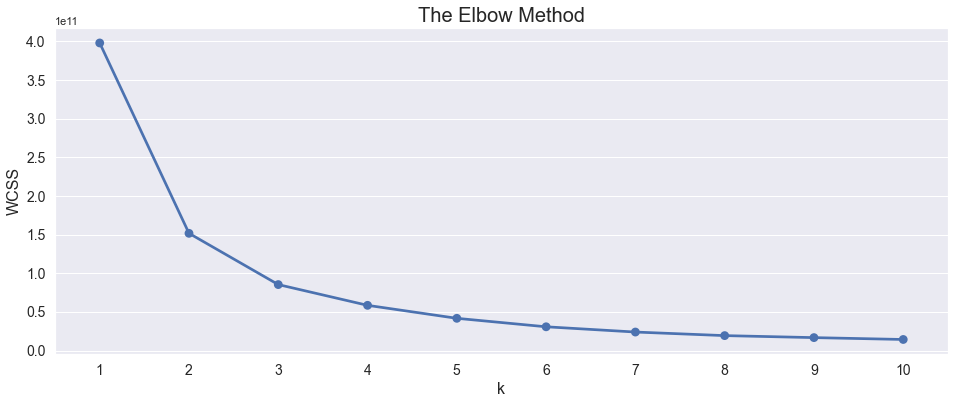

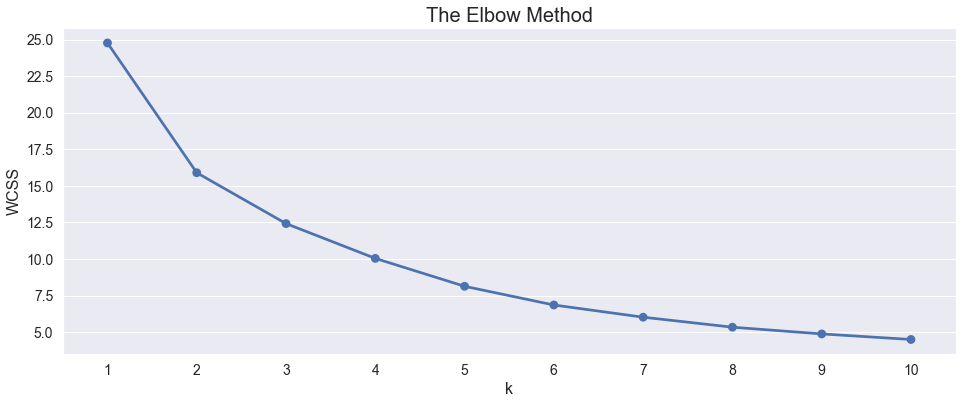

In [41]:
from sklearn.cluster import KMeans
wcss = {}
wcss_scaled = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(modeling_df)
    wcss[k] = kmeans.inertia_ # SSE to closest cluster centroid
    
    kmeans_scaled = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans_scaled.fit(scaled_df)
    wcss_scaled[k] = kmeans_scaled.inertia_

# Elbow Method
plt.figure(figsize=(16,6))
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.title('The Elbow Method', fontsize=20)
plt.xlabel('k', fontsize=16)
plt.ylabel('WCSS', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

# Elbow Method Σψαλεδ
plt.figure(figsize=(16,6))
sns.pointplot(x=list(wcss_scaled.keys()), y=list(wcss_scaled.values()))
plt.title('The Elbow Method', fontsize=20)
plt.xlabel('k', fontsize=16)
plt.ylabel('WCSS', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

###### Training the K-means model on the dataset

In [116]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
modeling_df["Cluster"] = kmeans.fit_predict(modeling_df)
display(modeling_df)

kmeans_scaled = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
scaled_df["Cluster"] = kmeans_scaled.fit_predict(scaled_df)
display(scaled_df)

,Quantity,UnitPrice,Amount,Products,Transactions,Cancelled,Cluster
CustomerID,,,,,,,
12346.0,0,2.08,0.00,2,2,1,0
12347.0,2458,481.21,4310.00,182,7,0,0
12348.0,2341,178.71,1797.24,31,4,0,0
12349.0,631,605.10,1757.55,73,1,0,0
12350.0,197,65.30,334.40,17,1,0,0
...,...,...,...,...,...,...,...
18280.0,45,47.65,180.60,10,1,0,0
18281.0,54,39.36,80.82,7,1,0,0
18282.0,98,62.68,176.60,13,3,1,0


,Quantity,UnitPrice,Amount,Products,Transactions,Cancelled,Cluster
CustomerID,,,,,,,
12346.0,0.001538,0.000050,0.015109,0.000128,0.004049,0.004425,0
12347.0,0.014014,0.011630,0.030297,0.023172,0.024291,0.000000,0
12348.0,0.013420,0.004319,0.021442,0.003841,0.012146,0.000000,0
12349.0,0.004741,0.014624,0.021303,0.009218,0.000000,0.000000,0
12350.0,0.002538,0.001578,0.016288,0.002048,0.000000,0.000000,0
...,...,...,...,...,...,...,...
18280.0,0.001766,0.001152,0.015746,0.001152,0.000000,0.000000,0
18281.0,0.001812,0.000951,0.015394,0.000768,0.000000,0.000000,0
18282.0,0.002035,0.001515,0.015731,0.001536,0.008097,0.004425,0


In [117]:
df_compare(scaled_df[modeling_df['Cluster']==0][["Cluster"]].head(15),
           scaled_df[modeling_df['Cluster']==1][["Cluster"]].head(15),
           scaled_df[modeling_df['Cluster']==2][["Cluster"]].head(15),
           scaled_df[modeling_df['Cluster']==3][["Cluster"]].head(15),
           df_ordering(modeling_df.groupby(['Cluster']).agg({'Cluster':'count'}).rename(columns={'Cluster': 'Customers'}),'Customers'),
           titles=[*[f'Cluster {i}' for i in range(n_clusters)], 'Overview'])

df_compare(scaled_df[scaled_df['Cluster']==0][["Cluster"]].head(15),
           scaled_df[scaled_df['Cluster']==1][["Cluster"]].head(15),
           scaled_df[scaled_df['Cluster']==2][["Cluster"]].head(15),
           scaled_df[scaled_df['Cluster']==3][["Cluster"]].head(15),
           df_ordering(scaled_df.groupby(['Cluster']).agg({'Cluster':'count'}).rename(columns={'Cluster': 'Customers'}),'Customers'),
           titles=[*[f'Cluster {i}' for i in range(n_clusters)], 'Overview'])

,Cluster
CustomerID,
12346.0,0
12347.0,0
12348.0,0
12349.0,0
12350.0,0
12352.0,0
12353.0,0
12354.0,0
12355.0,0


,Cluster
CustomerID,
12346.0,0
12347.0,0
12348.0,0
12349.0,0
12350.0,0
12352.0,0
12353.0,0
12354.0,0
12355.0,0


In [135]:
from sklearn.metrics import silhouette_score
print('Accuracy score unscaled:', silhouette_score(modeling_df, kmeans.labels_, metric='euclidean'))
print('Accuracy score:', silhouette_score(scaled_df, kmeans_scaled.labels_, metric='euclidean'))

Accuracy score unscaled: 0.9629935800457212
Accuracy score: 0.9681794476129045


In [119]:
average_df = modeling_df.groupby('Cluster').mean()
average_df

,Quantity,UnitPrice,Amount,Products,Transactions,Cancelled
Cluster,,,,,,
0,854.430182,279.393311,1438.546635,83.426041,4.662526,1.806303
1,38581.500000,7581.959091,59177.614545,1640.136364,71.681818,45.409091
2,109950.000000,4624.010000,241083.226667,956.000000,63.000000,7.000000


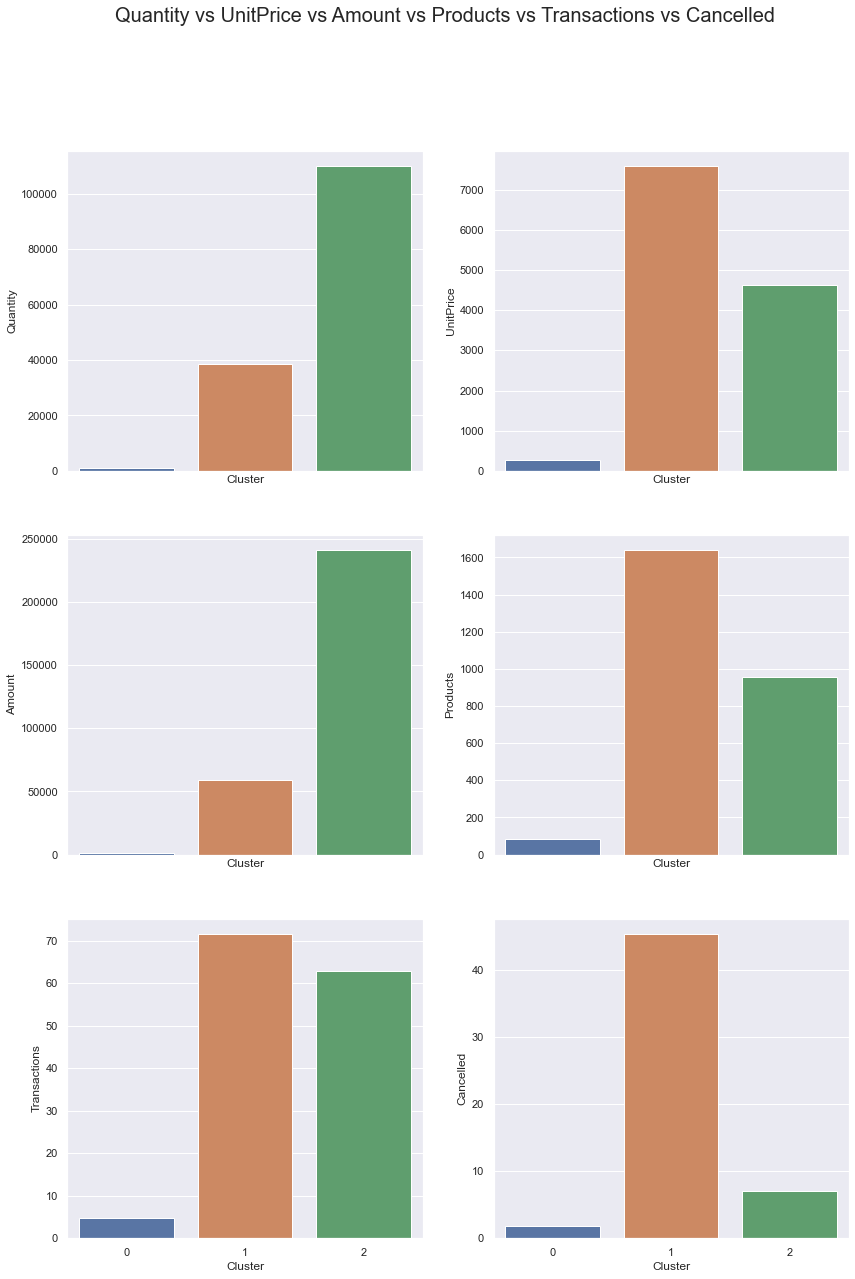

In [134]:
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(14,20))
fig.suptitle(' vs '.join(average_df.columns), fontsize=20)
column_list = average_df.columns.tolist()
for i in range(3):
    for j in range(2):
        sns.barplot(ax=axes[i, j], x=average_df.index, y=column_list.pop(0), data=average_df)

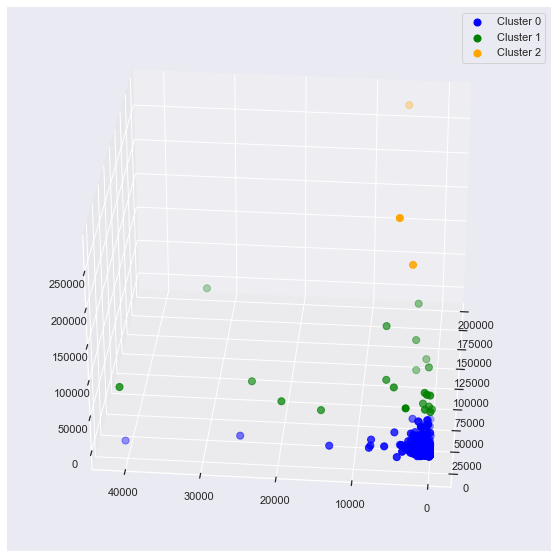

In [121]:
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
#['blue', 'green', 'red', 'yellow', 'orange', 'purple']

for k, color in zip(range(n_clusters), ['blue', 'green', 'orange', 'yellow']):
    ax.scatter(modeling_df[modeling_df['Cluster']==k]['Quantity'], modeling_df[modeling_df['Cluster']==k]['UnitPrice'], 
               modeling_df[modeling_df['Cluster']==k]['Amount'], s=50, c=color, label=f'Cluster {k}')

ax.view_init(30, 185)
plt.legend()
plt.show()

## Principal Component Analysis (PCA)

In [122]:
from sklearn.decomposition import PCA

n_component = 2
pca = PCA(n_component)
pca_df = pd.DataFrame(pca.fit_transform(scaled_df), columns=['Component_1', 'Component_2'])
pca_df = pd.concat([pca_df, scaled_df.reset_index()[['Cluster']]], axis=1)
pca_df

,Component_1,Component_2,Cluster
0,-0.073344,-0.009750,0
1,-0.068598,0.022487,0
2,-0.071612,0.001072,0
3,-0.072384,-0.000364,0
4,-0.073731,-0.011416,0
...,...,...,...
4367,-0.073864,-0.012370,0
4368,-0.073911,-0.012731,0
4369,-0.072771,-0.006035,0
4370,0.926960,-0.070158,1


###### Visualising the clusters

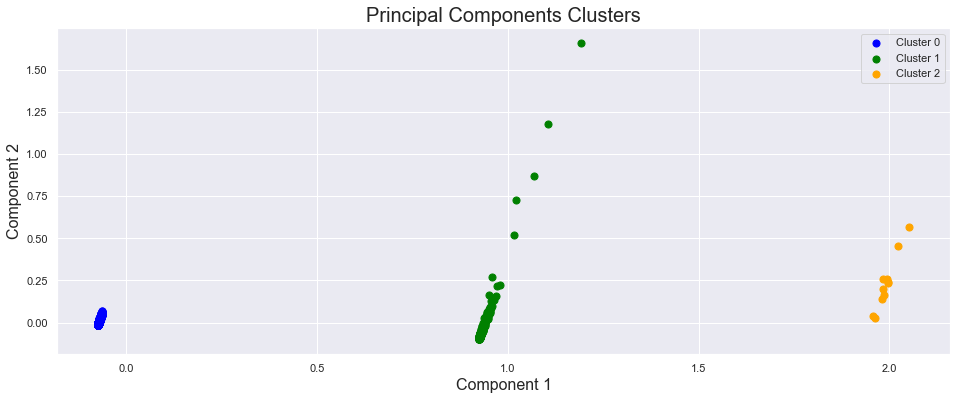

In [123]:
# fig = plt.figure(figsize=(16,6))
# ax = fig.add_subplot(1,1,1)
# colors = np.array(['blue', 'green', 'orange', 'yellow'])
# ax.scatter(x=pca_df.Component_1, y=pca_df.Component_2, c=colors[pca_df.Cluster], s=50)

plt.figure(figsize=(16,6))
plt.title('Principal Components Clusters', fontsize=20)
plt.xlabel('Component 1', fontsize=16)
plt.ylabel('Component 2', fontsize=16)

for k, color in zip(range(n_clusters), ['blue', 'green', 'orange', 'yellow']):
    plt.scatter(x=pca_df[pca_df['Cluster']==k][['Component_1']], 
                y=pca_df[pca_df['Cluster']==k][['Component_2']], s=50, c=color, label=f'Cluster {k}')
plt.legend()
plt.show()

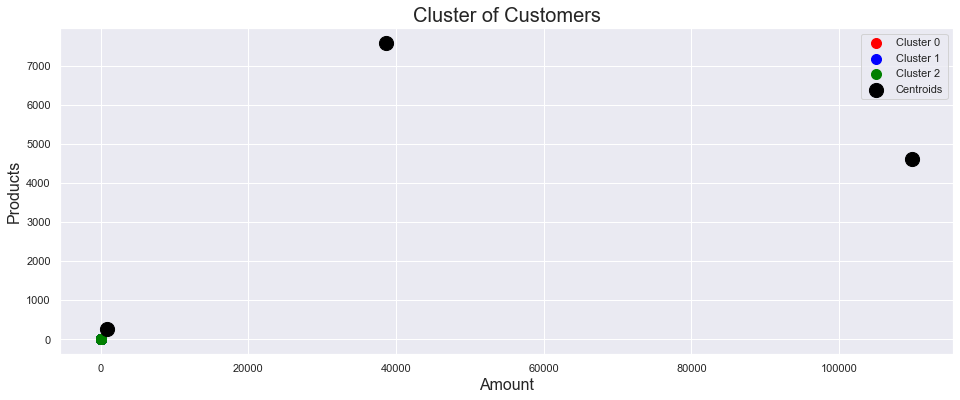

In [124]:
plt.figure(figsize=(16,6))
plt.title('Cluster of Customers', fontsize=20)
plt.xlabel('Amount', fontsize=16)
plt.ylabel('Products', fontsize=16)

for k, color in zip(range(n_clusters), ['red', 'blue', 'green']):
    plt.scatter(scaled_df[scaled_df['Cluster']==k][['Amount']], 
                scaled_df[scaled_df['Cluster']==k][['Products']], s= 100, c=color, label=f'Cluster {k}')

plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:, 1], s= 200, c='black', label='Centroids')
plt.legend()
plt.show()